# Carga y comprobaciones
- Carga cables.csv. Revisa tipos, valores nulos por columna, posibles duplicados y los rangos de las
variables.
- Elimina las columnas redudantes (vacías, valores constantes, índices, etc). 

## Primer paso
- Importaciones
- Leer el csv
- Imprimir por pantalla el tamaño

In [80]:
import pandas as pd
import numpy as np
import warnings, time
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold, cross_val_score
warnings.filterwarnings("ignore")

#Se define 'df1' con los datos de cables.csv para la primera parte en la que hay que eliminar valores NaN
df1 = pd.read_csv("cables.csv")
df2 = pd.read_csv("cables.csv")
#Print para comprobar que se ha cargado
print("Tamaño del dataframe:")
print(df1.shape)

Tamaño del dataframe:
(490, 8)


## Segundo paso
- Revisa tipos, valores nulos, etc
- Elimina columnas redundantes

In [81]:
# Número de valores perdidos
nan = df1.isna().sum()
print("Hay estos valores que son NaN en cada columna: \n", nan)

Hay estos valores que son NaN en cada columna: 
 Unnamed: 0     0
N              5
R             19
S             13
T             16
U              7
G              1
L              0
dtype: int64


In [82]:
#Revisamos las filas que están duplicadas
dup = df1.duplicated().sum()
print("Hay estas filas duplicadas: ", dup)

Hay estas filas duplicadas:  0


In [83]:
#Comprobamos el rango de las variables
df1.describe()

,Unnamed: 0,N,R,S,T,U,G,L
count,490.00000,485.000000,471.000000,477.000000,474.000000,483.000000,489.000000,490.000000
mean,245.50000,35.053608,499.023312,2239.754717,313.253165,3916.645963,1674.640082,1734.773469
std,141.59508,28.297293,248.861906,6214.925633,320.326768,2230.142048,1170.295112,1155.587275
min,1.00000,1.000000,60.000000,1.000000,3.000000,84.000000,-2103.000000,80.000000
25%,123.25000,16.000000,325.000000,256.000000,106.000000,1992.000000,923.000000,916.500000
50%,245.50000,27.000000,458.330000,729.000000,212.000000,3985.000000,1697.000000,1500.000000
75%,367.75000,45.000000,633.330000,2025.000000,401.000000,5920.000000,2443.000000,2222.750000
max,490.00000,200.000000,1673.330000,102400.000000,2800.000000,7668.000000,4946.000000,7675.000000


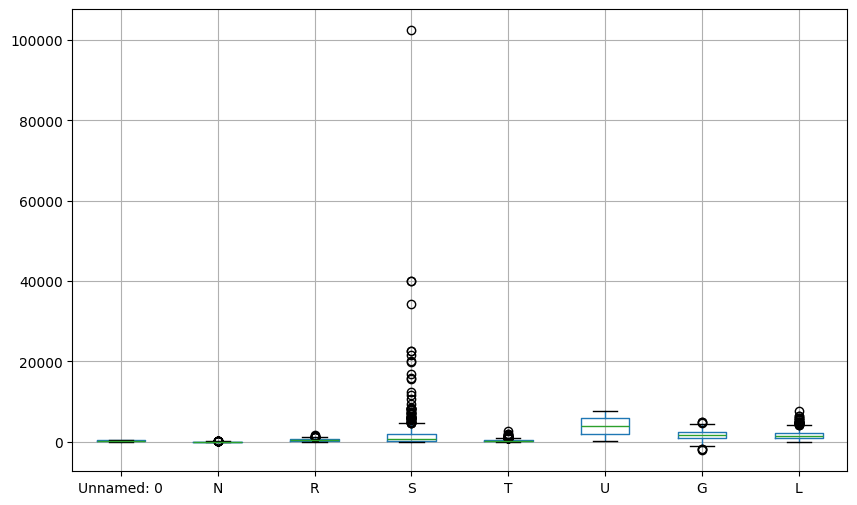

     Unnamed: 0      N        R         S       T       U       G     L
3             4   76.0   863.33    5776.0   745.0   974.0  2377.0  3411
7             8   83.0   460.00    6889.0   211.0  6064.0  2784.0  1885
9            10   92.0   793.33    8464.0   629.0  1613.0   594.0  1855
34           35   90.0   341.67    8100.0   116.0  7367.0  -361.0  1623
39           40   80.0  1166.67    6400.0  1361.0  6746.0  2421.0  3430
41           42  141.0   966.67   19881.0   934.0   183.0   950.0  6465
53           54   79.0   416.67    6241.0   173.0  2891.0   762.0  2557
68           69   69.0   466.67    4761.0   217.0  5558.0  1753.0  3096
78           79  108.0      NaN   11664.0   374.0   326.0  3672.0  2764
108         109   74.0   613.33    5476.0   376.0  2360.0  1621.0  1675
130         131   77.0   560.00    5929.0   313.0  2943.0  1615.0  1880
135         136   70.0   591.67    4900.0   350.0  7381.0   932.0  3221
136         137   75.0   346.67    5625.0   120.0  3423.0  2885.

In [84]:
#Hacemos un boxplot para ver todos los outliers
import matplotlib.pyplot as plt

df1.boxplot(figsize=(10,6))
plt.show()
# Ejemplo: detectar outliers usando el rango intercuartílico (IQR)
Q1 = df1['S'].quantile(0.25)
Q3 = df1['S'].quantile(0.75)
IQR = Q3 - Q1

outliers = df1[(df1['S'] < Q1 - 1.5*IQR) | (df1['S'] > Q3 + 1.5*IQR)]
print(outliers)



In [85]:
#Eliminamos ahora las columnas redundantes
#Las columnas U y G son distractoras, por lo que no aportan nada realmente, por lo que de momento serán eliminadas
#También se elimina la primera columna que es sólo un índice
df1 = df1.drop(columns=['Unnamed: 0'])
#df = df.drop(columns=['U', 'G'])
print(df1.columns)


Index(['N', 'R', 'S', 'T', 'U', 'G', 'L'], dtype='object')


## Resumen de como ha quedado el dataframe después de esto

In [86]:
print("=== Resumen del dataset ===")
print("Tamaño del DataFrame:", df1.shape)
print("\nColumnas:", df1.columns.tolist())
print("\nValores faltantes por columna:\n", df1.isna().sum())
print("\nDuplicados totales:", df1.duplicated().sum())
print("\nEstadísticos descriptivos:\n", df1.describe())

=== Resumen del dataset ===
Tamaño del DataFrame: (490, 7)

Columnas: ['N', 'R', 'S', 'T', 'U', 'G', 'L']

Valores faltantes por columna:
 N     5
R    19
S    13
T    16
U     7
G     1
L     0
dtype: int64

Duplicados totales: 0

Estadísticos descriptivos:
                 N            R              S            T            U  \
count  485.000000   471.000000     477.000000   474.000000   483.000000   
mean    35.053608   499.023312    2239.754717   313.253165  3916.645963   
std     28.297293   248.861906    6214.925633   320.326768  2230.142048   
min      1.000000    60.000000       1.000000     3.000000    84.000000   
25%     16.000000   325.000000     256.000000   106.000000  1992.000000   
50%     27.000000   458.330000     729.000000   212.000000  3985.000000   
75%     45.000000   633.330000    2025.000000   401.000000  5920.000000   
max    200.000000  1673.330000  102400.000000  2800.000000  7668.000000   

                 G            L  
count   489.000000   490.00000

# Análisis exploratorio
- Distribución de L (histograma) y relaciones L–N y L–R (gráficos de dispersión con tendencia).
- Segmenta por tamaño de municipio (es decir, repite los gráficos anteriores para los municipios con
menos habitantes que la media y para los municipios con más habitantes que la media) y
comprueba visualmente si hay diferencias.
- Razona qué señales parecen explicar mejor L.
- Identifica los puntos anómalos (outliers) en los gráficos de dispersión

## Histograma

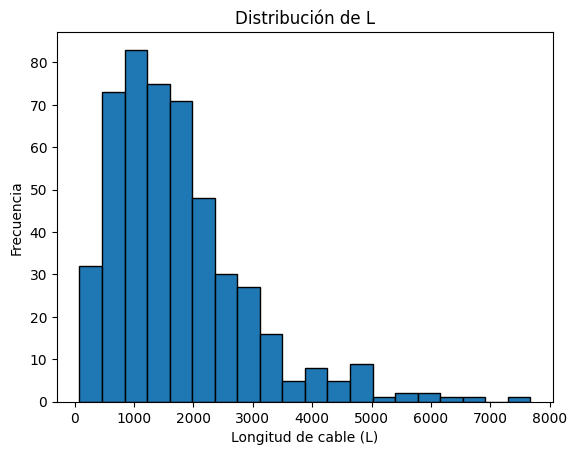

In [87]:
plt.hist(df1['L'], bins=20, edgecolor='black')
plt.title("Distribución de L")
plt.xlabel("Longitud de cable (L)")
plt.ylabel("Frecuencia")
plt.show()

plt.show()

## Gráficos de dispersión

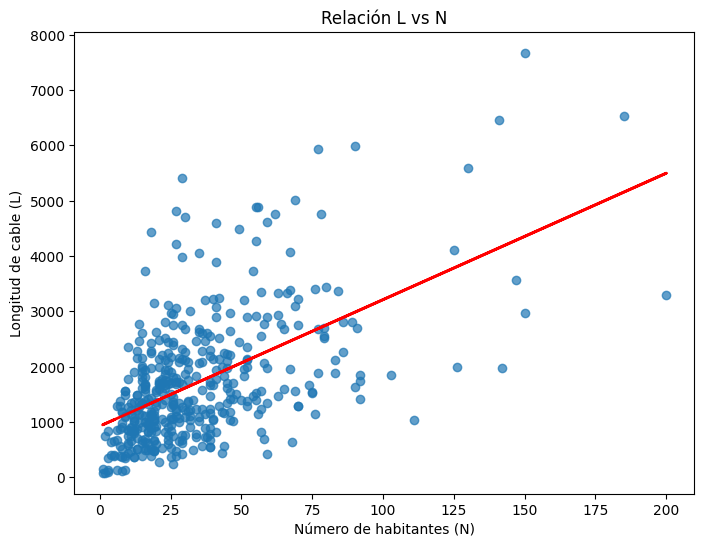

In [88]:
# Scatter plot L vs N
from sklearn.linear_model import LinearRegression

# Línea de tendencia (regresión lineal simple)
X = df1.dropna()[['N']]
y = df1.dropna()['L']

model = LinearRegression()
model.fit(X,y)

#Los puntos
plt.figure(figsize=(8,6))
plt.scatter(X, y, alpha=0.7, label="Datos")

#La línea
plt.plot(X, model.predict(X), color='red', linewidth=2, label="Tendencia")
plt.title("Relación L vs N")
plt.xlabel("Número de habitantes (N)")
plt.ylabel("Longitud de cable (L)")
plt.show()



In [89]:
# Scatter plot L vs R
plt.scatter(df1['R'], df1['L'], alpha=0.7)
# Línea de tendencia
df1.dropna()
m, b = np.polyfit(df1['R'], df1['L'], 1)
plt.plot(df1['R'], m*df1['R'] + b, color='red', linewidth=2)
plt.title("Relación L vs R")
plt.xlabel("Radio del municipio (R)")
plt.ylabel("Longitud de cable (L)")
plt.show()

** On entry to DLASCL, parameter number  4 had an illegal value
** On entry to DLASCL, parameter number  4 had an illegal value
** On entry to DLASCL, parameter number  4 had an illegal value
** On entry to DLASCL, parameter number  4 had an illegal value
** On entry to DLASCL, parameter number  5 had an illegal value
** On entry to DLASCL, parameter number  4 had an illegal value


LinAlgError: SVD did not converge in Linear Least Squares

## Gráficos de dispersión separados por la media

Gráfico de L vs N

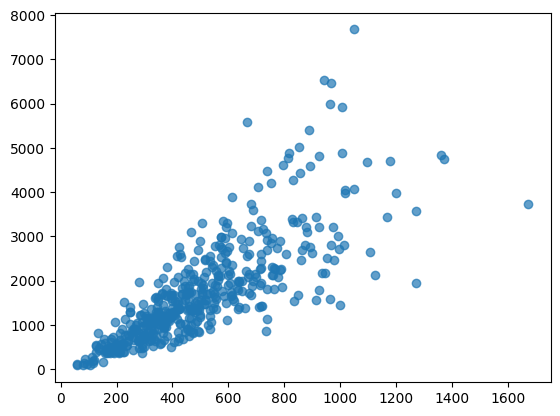

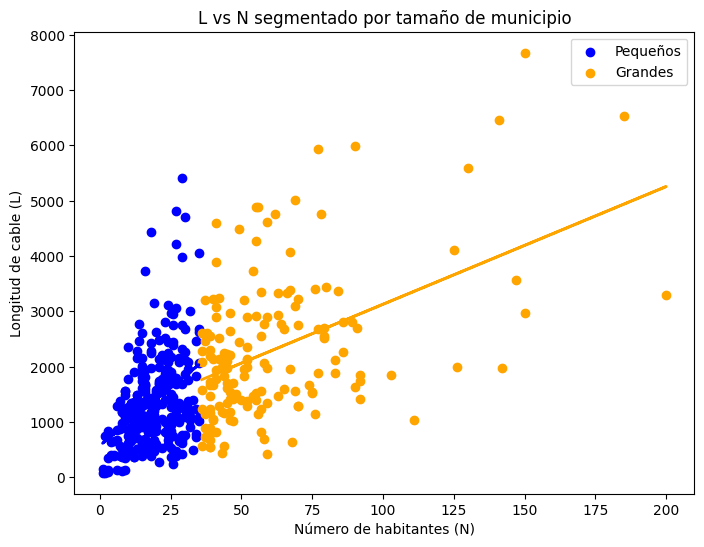

In [ ]:
# Calculamos la media
media = np.mean(df1['N'])

#Separamos en municipios grandes y pequeños
dfSmall = df1.dropna()[df1['N'] < media]
dfBig = df1.dropna()[df1['N'] >= media]

#Gráfico de L vs N
plt.figure(figsize=(8,6))

#Municipios pequeños
plt.scatter(dfSmall['N'], dfSmall['L'], color='blue', label="Pequeños")
m,b = np.polyfit(dfSmall['N'], dfSmall['L'], 1)
plt.plot(dfSmall['N'], m*dfSmall['N'] + b, color='blue', linewidth=2)

#Municipios grandes
plt.scatter(dfBig['N'], dfBig['L'], color='orange', label="Grandes")
m,b = np.polyfit(dfBig['N'], dfBig['L'], 1)
plt.plot(dfBig['N'], m*dfBig['N'] + b, color='orange', linewidth=2)

plt.title("L vs N segmentado por tamaño de municipio")
plt.xlabel("Número de habitantes (N)")
plt.ylabel("Longitud de cable (L)")
plt.legend()
plt.show()


Gráfico de L vs R

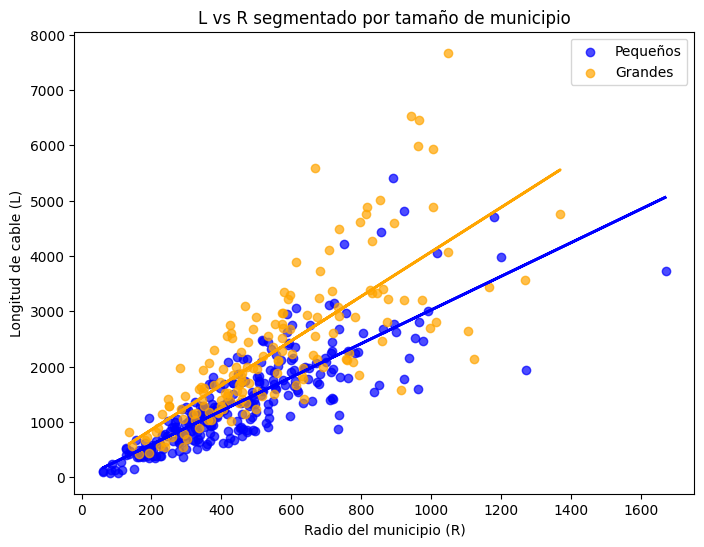

In [ ]:
plt.figure(figsize=(8,6))

#Municipios pequeños
XSmall = dfSmall[['R']]
ySmall = dfSmall['L']
modelSmall = LinearRegression().fit(XSmall, ySmall)
plt.scatter(XSmall, ySmall, color='blue', alpha=0.7, label='Pequeños')
plt.plot(XSmall, modelSmall.predict(XSmall), color='blue', linewidth=2)

#Municipios pequeños
XBig = dfBig[['R']]
yBig = dfBig[['L']]
modelBig = LinearRegression().fit(XBig, yBig)
plt.scatter(XBig, yBig, color='orange',alpha=0.7,label="Grandes")
plt.plot(XBig, modelBig.predict(XBig), color='orange', linewidth=2)

plt.title("L vs R segmentado por tamaño de municipio")
plt.xlabel("Radio del municipio (R)")
plt.ylabel("Longitud de cable (L)")
plt.legend()
plt.show()

### Razonamiento a incluir en el documento
Dado que los puntos en el gráfico de dispersión están distribuidos más próximos a la línea, hay una correlación mayor entre ambas variables que entre L y N, por lo que la variable R se podría decir que explica mejor los valores de la variable L

Identifiación de puntos anómalos en los gráficos de dispersión. Se usa el rango intercuartílico para detectar outliers en cada grupo

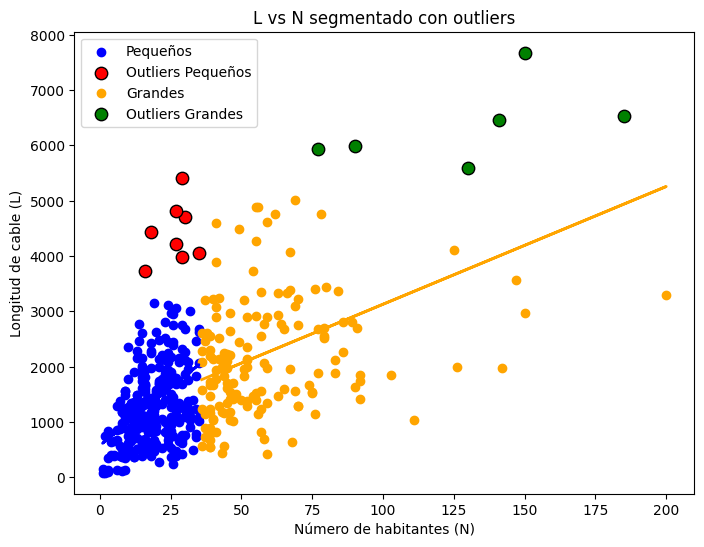

In [ ]:
#Media de N
media = df1['N'].mean()

dfSmall = df1.dropna()[df1['N'] < media]   # menos habitantes que la media
dfBig = df1.dropna()[df1['N'] >= media]  # igual o más habitantes que la media

# Función auxiliar para detectar los outliers mediante el uso de IQR
def detectar_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    # True para los outliers
    return (series < Q1 - 1.5*IQR) | (series > Q3 + 1.5*IQR)

# L vs N
plt.figure(figsize=(8,6))

# Pequeños
outliersSmall = detectar_outliers(dfSmall['L'])
plt.scatter(dfSmall['N'], dfSmall['L'], color='blue', label='Pequeños')
plt.scatter(dfSmall['N'][outliersSmall], dfSmall['L'][outliersSmall],
            color='red', edgecolor='black', s=80, label='Outliers Pequeños')  # outliers resaltados
m, b = np.polyfit(dfSmall['N'], dfSmall['L'], 1)
plt.plot(dfSmall['N'], m*dfSmall['N'] + b, color='blue', linewidth=2)

# Grandes
outliersBig = detectar_outliers(dfBig['L'])
plt.scatter(dfBig['N'], dfBig['L'], color='orange', label='Grandes')
plt.scatter(dfBig['N'][outliersBig], dfBig['L'][outliersBig],
            color='green', edgecolor='black', s=80, label='Outliers Grandes')  # outliers resaltados
m, b = np.polyfit(dfBig['N'], dfBig['L'], 1)
plt.plot(dfBig['N'], m*dfBig['N'] + b, color='orange', linewidth=2)

plt.title("L vs N segmentado con outliers")
plt.xlabel("Número de habitantes (N)")
plt.ylabel("Longitud de cable (L)")
plt.legend()
plt.show()


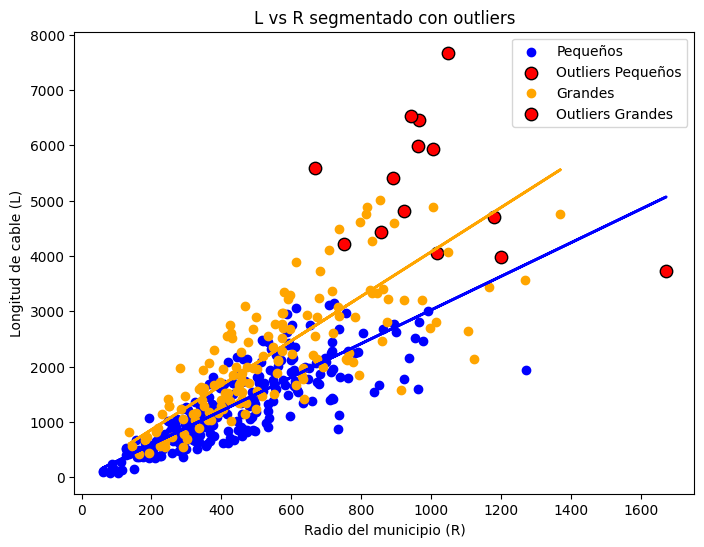

In [ ]:
# 4️⃣ L vs R segmentado con outliers
plt.figure(figsize=(8,6))

# Pequeños
outliersSmall = detectar_outliers(dfSmall['L'])
plt.scatter(dfSmall['R'], dfSmall['L'], color='blue', label='Pequeños')
plt.scatter(dfSmall['R'][outliersSmall], dfSmall['L'][outliersSmall],
            color='red', edgecolor='black', s=80, label='Outliers Pequeños')
m, b = np.polyfit(dfSmall['R'], dfSmall['L'], 1)
plt.plot(dfSmall['R'], m*dfSmall['R'] + b, color='blue', linewidth=2)

# Grandes
outliersBig = detectar_outliers(dfBig['L'])
plt.scatter(dfBig['R'], dfBig['L'], color='orange', label='Grandes')
plt.scatter(dfBig['R'][outliersBig], dfBig['L'][outliersBig],
            color='red', edgecolor='black', s=80, label='Outliers Grandes')
m, b = np.polyfit(dfBig['R'], dfBig['L'], 1)
plt.plot(dfBig['R'], m*dfBig['R'] + b, color='orange', linewidth=2)

plt.title("L vs R segmentado con outliers")
plt.xlabel("Radio del municipio (R)")
plt.ylabel("Longitud de cable (L)")
plt.legend()
plt.show()

# Tratamiento de valores perdidos
- Empieza con una estrategia simple (media o mediana) y valida con K-fold
- Si procede, compara con KNNImputer o IterativeImputer.

## Separación de variables predictoras y variables objetivo

Se asume que L es la variable objetivo (lo pone el ejercicio)

In [92]:
X = df2[['N', 'R', 'S', 'T', 'U', 'G']]
y = df2['L']

## Imputación de valores faltantes

Usando un `SimpleImputer` con la media

In [103]:
imputer  = SimpleImputer(strategy="mean")

XImputed = imputer.fit_transform(X)

## Validación con `K-Fold`

Y usando validación cruzada para comprobar calidad del modelo lineal con los datos imputados

In [104]:
model = LinearRegression()

kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model, XImputed, y, cv=kf, scoring='r2')

print("Resultados de validación cruzada (R²):")
print(scores)
print("Media del R²:", np.mean(scores))

Resultados de validación cruzada (R²):
[0.59779197 0.74300369 0.70467373 0.69634493 0.54317706]
Media del R²: 0.656998275460171
